In [ ]:
# Install Dependencies
'''
Ultralytics = YOLOv8
Roboflow = for dataset
'''
!pip install ultralytics
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 127.5 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [ ]:
# Import Required Libraries
import numpy as np
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt
import torch
from roboflow import Roboflow
from IPython.display import Image, display
import os
import json
import random

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# Download Dataset from Roboflow
rf = Roboflow(api_key="API Key") # Replace with your Roboflow key
project = rf.workspace("roboflow-universe-projects").project("license-plate-recognition-rxg4e")
version = project.version(4)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to License-Plate-Recognition-4 in yolov8:: 100%|██████████| 48488/48488 [00:07<00:00, 6173.97it/s]


In [ ]:
# Detect device (GPU if available, else CPU)
if torch.cuda.is_available():
    device=0 # GPU
    gpu_props=torch.cuda.get_device_properties(0)
    gpu_mem_gb=gpu_props.total_memory / (1024 ** 3)
    print(f"Using GPU: {gpu_props.name}, VRAM: {gpu_mem_gb:.1f} GB")

    # Auto batch size selection
    if gpu_mem_gb < 8:
        batch_size=8    # small GPU
    elif gpu_mem_gb < 16:
        batch_size=16   # medium GPU
    else:
        batch_size=32   # big GPU
else:
    device = "cpu"
    batch_size = 4  # keep small for CPU
    print("No GPU found, training on CPU (much slower).")

print(f"Auto-selected batch size: {batch_size}")

Using GPU: Tesla T4, VRAM: 14.7 GB
Auto-selected batch size: 16


In [ ]:
# Check dataset folder contents (confirm train/valid/test and data.yaml exist)
!ls '/content/License-Plate-Recognition-4'

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


In [ ]:
# Check image shapes from train, validation, and test sets and verify that their dimensions are consistent with YOLO requirements

# Training image
image = cv2.imread('/content/License-Plate-Recognition-4/train/images/000f52302c1341eb_jpg.rf.028c5ec713dda16a298af755e43e1847.jpg')
height, width = image.shape[:2]
print(f'Shape of training image: {height}, {width}')

# Validation image
image = cv2.imread('/content/License-Plate-Recognition-4/valid/images/00b6f96c840767fa_jpg.rf.ee1edf91f58203d50b54a53454296a1e.jpg')
height, width = image.shape[:2]
print(f'Shape of validation image: {height}, {width}')

# Test image
image = cv2.imread('/content/License-Plate-Recognition-4/test/images/00a7d31c6cc6b7f3_jpg.rf.2707e63f5c51f113de704441ea210a65.jpg')
height, width = image.shape[:2]
print(f'Shape of test image: {height}, {width}')

Shape of training image: 640, 640
Shape of validation image: 640, 640
Shape of test image: 640, 640


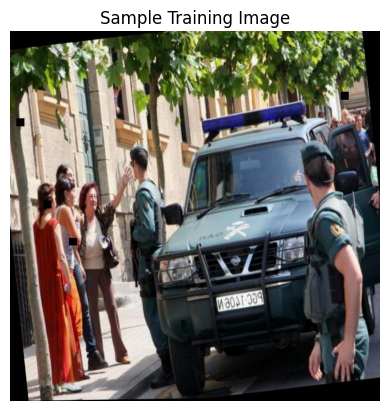

In [ ]:
# Display a sample training image
img = cv2.imread('/content/License-Plate-Recognition-4/train/images/000f52302c1341eb_jpg.rf.028c5ec713dda16a298af755e43e1847.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Sample Training Image")
plt.axis("off")
plt.show()

In [ ]:
# Edit YOLO data.yaml file

%%writefile /content/License-Plate-Recognition-4/data.yaml

# Paths to train/val/test image directories
train: /content/License-Plate-Recognition-4/train/images
val: /content/License-Plate-Recognition-4/valid/images
test: /content/License-Plate-Recognition-4/test/images

# Number of classes
nc: 1

# Class names
names: ['License_Plate']

Overwriting /content/License-Plate-Recognition-4/data.yaml


In [ ]:
# Load Model
model=YOLO("yolov8n.pt")

# Train model with optimized settings
results=model.train(
    data="/content/License-Plate-Recognition-4/data.yaml",
    epochs=47,         # max epochs
    batch=batch_size,  # auto batch size
    imgsz=640,         # standard YOLO size
    patience=10,       # early stop if no improvement in 10 epochs
    workers=2,         # keeps RAM usage low in Colab
    device=device,     # ensure it uses GPU
    exist_ok=True
)

Ultralytics 8.3.195 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/License-Plate-Recognition-4/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=47, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots=True, pose=12.

In [ ]:
import json
# Run evaluation
metrics = model.val(
    data="/content/License-Plate-Recognition-4/data.yaml",
    save=True,
    save_txt=False,
    save_conf=True,
    exist_ok=True
    )

# Print MEAN metrics
print("\nEvaluation Metrics (averaged):")
print(f" Precision (P):     {np.mean(metrics.box.p):.4f}")
print(f" Recall (R):        {np.mean(metrics.box.r):.4f}")
print(f" F1 Score:          {np.mean(metrics.box.f1):.4f}")
print(f" mAP@0.5:           {np.mean(metrics.box.map50):.4f}")
print(f" mAP@0.5:0.95:      {np.mean(metrics.box.map):.4f}")
print("=" * 100)

# Results directory
results_dir = metrics.save_dir
print(f"Results saved to: {results_dir}")

# Save FULL metrics (JSON)
metrics_dict = {
    "mean": {
        "precision": float(np.mean(metrics.box.p)),
        "recall": float(np.mean(metrics.box.r)),
        "f1": float(np.mean(metrics.box.f1)),
        "map50": float(np.mean(metrics.box.map50)),
        "map": float(np.mean(metrics.box.map)),
        },
    "per_class": {
        "precision": metrics.box.p.tolist(),
        "recall": metrics.box.r.tolist(),
        "f1": metrics.box.f1.tolist(),
        "map50": metrics.box.map50.tolist(),
        "map": metrics.box.map.tolist(),
        }
    }

metrics_path = os.path.join(results_dir, "metrics.json")
with open(metrics_path, "w") as f:
  json.dump(metrics_dict, f, indent=4)
print(f"Metrics JSON saved at: {metrics_path}")
print("Evaluation complete!")

Ultralytics 8.3.195 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 960.8±230.5 MB/s, size: 34.5 KB)
val: Scanning /content/License-Plate-Recognition-4/valid/labels.cache... 2046 images, 3 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2046/2046 3.9Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 128/128 6.7it/s 19.1s
                   all       2046       2132      0.984      0.957      0.984      0.709
Speed: 0.4ms preprocess, 3.7ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to /content/runs/detect/train

Evaluation Metrics (averaged):
 Precision (P):     0.9838
 Recall (R):        0.9573
 F1 Score:          0.9704
 mAP@0.5:           0.9839
 mAP@0.5:0.95:      0.7089
Results saved to: /content/runs/detect/train
Metrics JSON saved at: /content/runs/detect

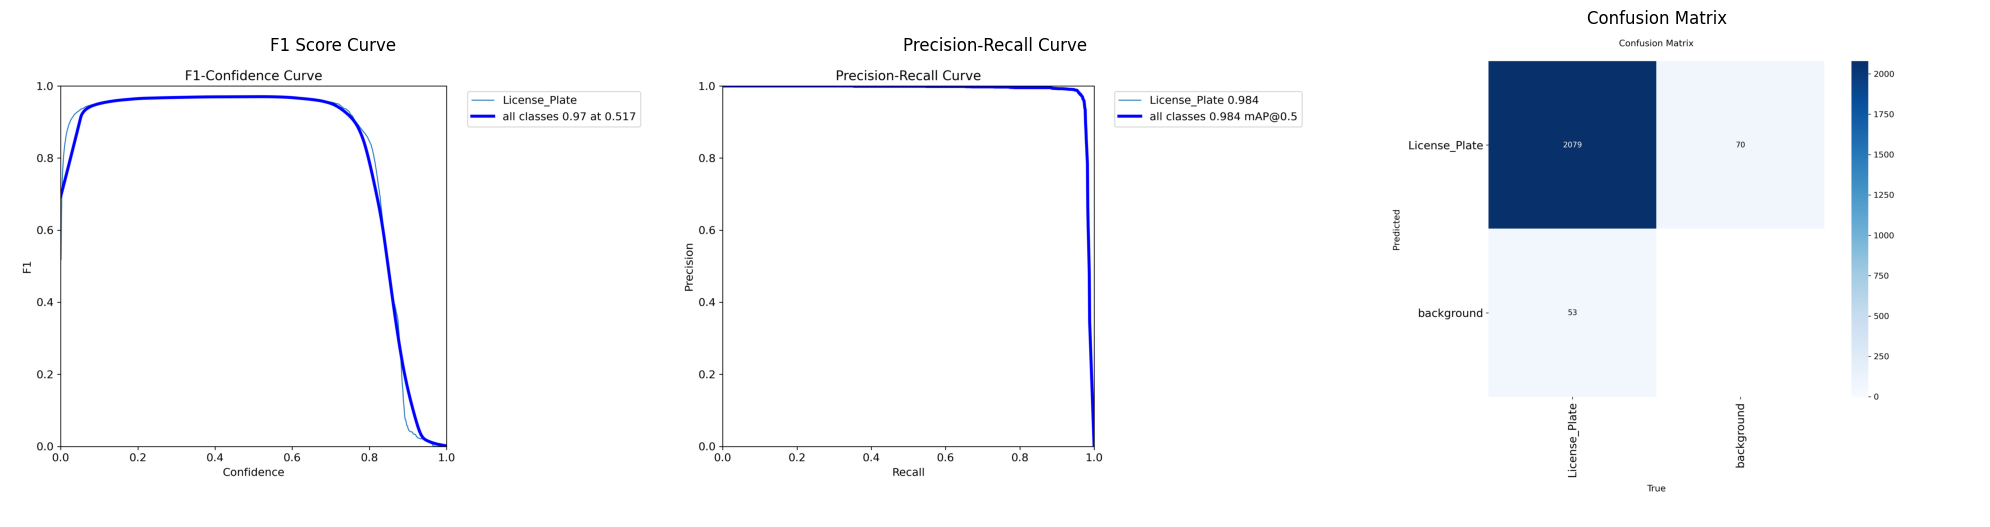

In [ ]:
# Paths to plots (change 'train2' if needed)
plot_paths = [
    "/content/runs/detect/train/BoxF1_curve.png",
    "/content/runs/detect/train/BoxPR_curve.png",
    "/content/runs/detect/train/confusion_matrix.png"
]

titles = ["F1 Score Curve", "Precision-Recall Curve", "Confusion Matrix"]

plt.figure(figsize=(20, 10))

for i, (path, title) in enumerate(zip(plot_paths, titles)):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")

# Display plots
plt.tight_layout()
plt.show()

In [ ]:
# Run inference on test images
test_results = model.predict(
    source="/content/License-Plate-Recognition-4/test/images",  # path to test images
    conf=0.25,   # confidence threshold (filter weak detections)
    save=True,   # save predicted images with bounding boxes
    device=device  # use GPU if available, otherwise CPU
)

# Show the path of first prediction result
print("Predictions saved in:", test_results[0].save_dir)


WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/1019 /content/License-Plate-Recognition-4/test/images/0002a5b67e5f0909_jpg.rf.07ca41e79eb878b14032f650f34d0967.jpg: 640x640 2 License_Plates, 8.2ms
image 2/1019 /content/License-Plate-Recognition-4/test/images/000812dcf304a8e7_jpg.rf.559f904bc045f68ee947796a1b561d8f.jpg: 640x640 1 License_Plate, 7.1ms
image 3/1019 /content/License-Plate-Recognition-4/test/images/0010f4c10f7ab07e_jpg.rf.92344aa620e23aacc490273e32343595.jpg: 640x640 1 License_Pla

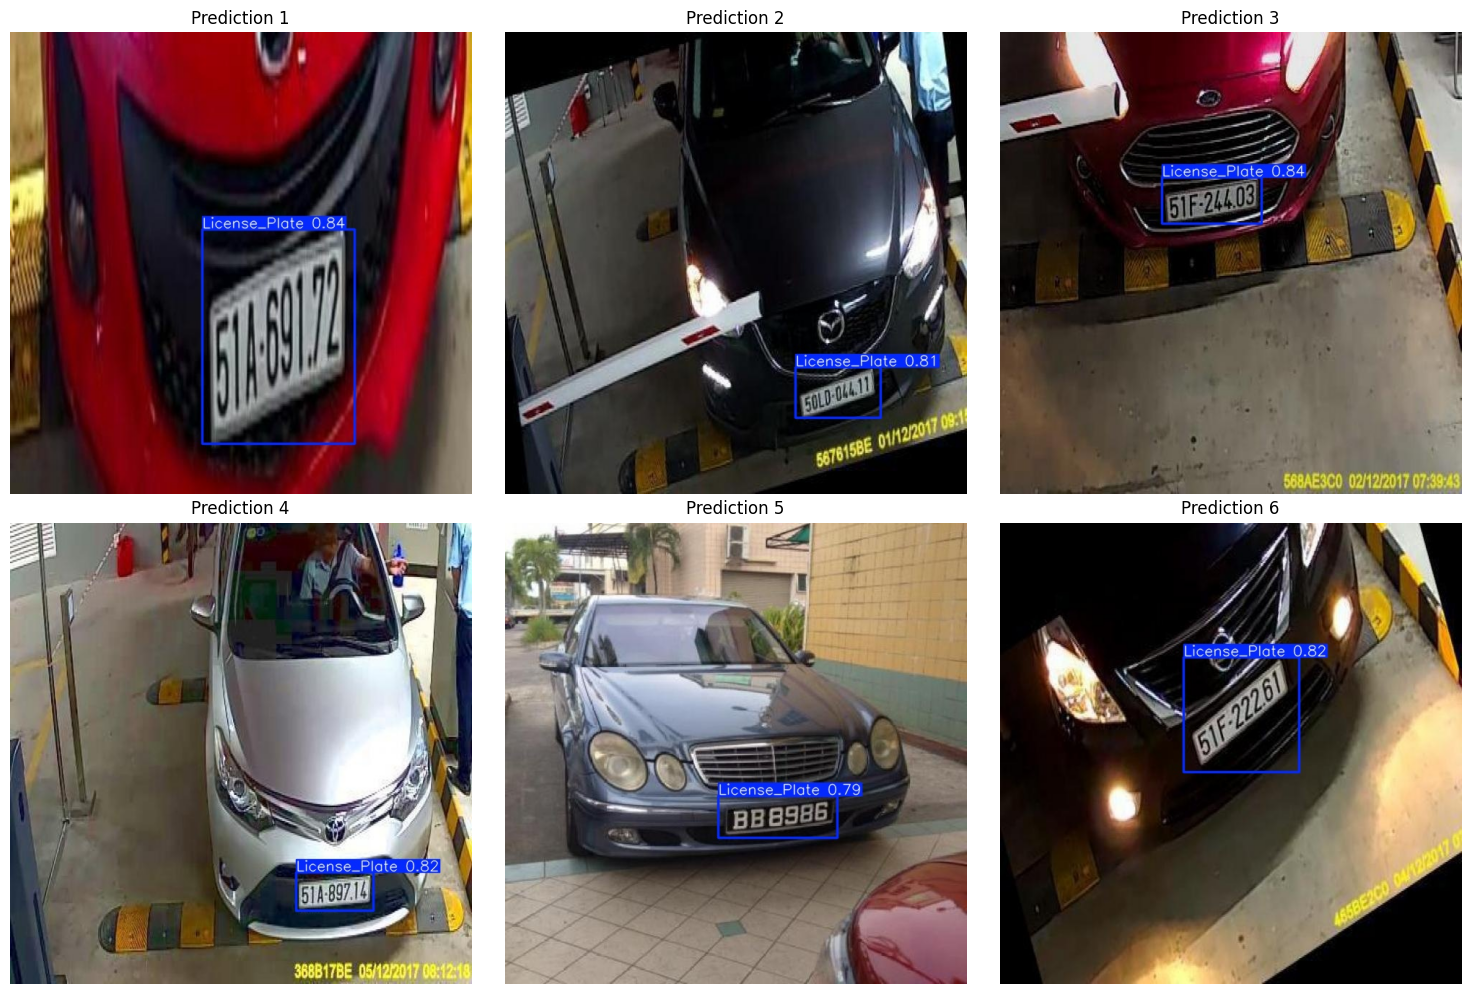

In [ ]:
# Display a grid of predicted test images with YOLO results

# Get the directory where predictions are saved
save_dir = test_results[0].save_dir

# Collect all predicted images
predicted_images = [os.path.join(save_dir, f) for f in os.listdir(save_dir) if f.endswith(('.jpg', '.png'))]

# Pick a random subset
num_samples = min(6, len(predicted_images))
random_images = random.sample(predicted_images, num_samples)

# Plot images
plt.figure(figsize=(15, 10))
for i, img_path in enumerate(random_images):
  img = cv2.imread(img_path)
  if img is None:
    print(f"Could not load {img_path}, skipping...")
    continue
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  plt.subplot(2, 3, i + 1)
  plt.imshow(img)
  plt.title(f"Prediction {i+1}")
  plt.axis("off")

plt.tight_layout()
plt.show()

# Insights from Training
* High Precision, Slightly Lower Recall
→ The model rarely mislabels license plates but may miss some in challenging scenarios.

* mAP@0.5 > 0.97
→ Strong bounding box accuracy confirms effective plate localization.

* Best Performance Conditions
→ Works well on daylight, front-facing plates, but struggles more on blurred, angled, or night-time images.

# Future Improvements

* Benchmark different YOLOv8 variants (n, s, m) for speed vs. accuracy trade-offs.


* Add data augmentations (motion blur, glare, low-light, occlusion).

* Fine-tune the OCR pipeline (EasyOCR/Tesseract) after detection.

# Conclusion:

* This training notebook successfully demonstrates that YOLOv8 is effective for license plate detection with strong precision and bounding box accuracy.

# Next Steps:
* Integrate detection with OCR (EasyOCR/Tesseract) for a complete ANPR pipeline.

* Test robustness on diverse real-world conditions (night, rain, fast motion).

* Optimize model deployment for real-time inference (edge devices, CCTV systems).